# Part 1

## Part 1A Pull The CHCN Data

In [ ]:
# Taken from demo notebook.
# Pull station geographical data

import pandas as pd

stn_ids = pd.read_fwf(
    'http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt',
    header=None,
    infer_nrows=1000)
stn_ids.columns = ['ID', 'LAT', 'LON', 'ELEV', 'UKN', 'NAME', 'GSN', 'WBAN']
# stn_ids

## Part 1B: Create a function to allow a station ID to be entered
### Instructions don't specifically call for this, but makes this flexible for multiple stations

In [ ]:
def get_station_id():
    station_id = input("Enter the station ID (e.g., USC00454572): ").strip()
    return station_id


# Example usage
selected_station_id = get_station_id()
print(f"You selected: {selected_station_id}")

You selected: USC00454572


## Part 1C: Create a dataframe that has station metadata

In [3]:
# Filter to a specific station (Leavenworth, WA)
selected_station = stn_ids[stn_ids['ID'] == selected_station_id]
print(selected_station)

                 ID      LAT      LON   ELEV UKN             NAME  GSN  WBAN
121807  USC00454572  47.5586 -120.675  343.8  WA  LEAVENWORTH 3 S  NaN   NaN


## Part 1D: Use selected station to create a URL to pull data values
### Also filter to 1991 to 2021

In [4]:
# Note worked with MS copilot on elements of URL and read_csv options

url = f"s3://noaa-ghcn-pds/csv/by_station/{selected_station_id}.csv"

df = pd.read_csv(
    url,
    storage_options={"anon": True},
    dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
    parse_dates=['DATE']
).set_index('DATE')

# Index and sort the date column:
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# Filter to 1991-2020
df_1991_2020 = df.loc['1991-01-01':'2020-12-31']

C:\Users\jared\AppData\Local\Temp\ipykernel_40108\3220525118.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [5]:
print(df_1991_2020)

                     ID ELEMENT  DATA_VALUE M_FLAG Q_FLAG S_FLAG  OBS_TIME
DATE                                                                      
1991-01-01  USC00454572    SNOW          20    NaN    NaN      0       NaN
1991-01-01  USC00454572    PRCP          30    NaN    NaN      0    1600.0
1991-01-01  USC00454572    TOBS         -72    NaN    NaN      0    1600.0
1991-01-01  USC00454572    TMAX         -33    NaN    NaN      0    1600.0
1991-01-01  USC00454572    TMIN        -178    NaN    NaN      0    1600.0
...                 ...     ...         ...    ...    ...    ...       ...
2020-12-31  USC00454572    TMIN         -28    NaN    NaN      7     800.0
2020-12-31  USC00454572    PRCP          13    NaN    NaN      7     800.0
2020-12-31  USC00454572    TOBS          -6    NaN    NaN      7     800.0
2020-12-31  USC00454572    SNOW          10    NaN    NaN      7       NaN
2020-12-31  USC00454572    SNWD         432    NaN    NaN      7     800.0

[59470 rows x 7 columns]

## Part 1E: Create a function to pull all elements and return result
### Note I worked on each data frame individually and ran through MS Copilot to create a single function to merge all.

In [6]:
def build_station_temperature_summary(df, df_1991_2020, selected_station):
    # Record min temp per station (lowest TMIN from 1991–2020)
    tmin_summary = (
        df_1991_2020[df_1991_2020['ELEMENT'] == 'TMIN']
        .groupby('ID')['DATA_VALUE']
        .min()
        .reset_index()
        .rename(columns={'DATA_VALUE': 'record_min_temp'})
    )

    # Record max temp per station (highest TMAX from 1991–2020)
    tmax_summary = (
        df_1991_2020[df_1991_2020['ELEMENT'] == 'TMAX']
        .groupby('ID')['DATA_VALUE']
        .max()
        .reset_index()
        .rename(columns={'DATA_VALUE': 'record_max_temp'})
    )

    # Average TMIN per station (full dataset)
    avg_tmin_df = (
        df[df['ELEMENT'] == 'TMIN']
        .groupby('ID')['DATA_VALUE']
        .mean()
        .reset_index()
        .rename(columns={'DATA_VALUE': 'average_min_temp'})
    )

    # Average TMAX per station (full dataset)
    avg_tmax_df = (
        df[df['ELEMENT'] == 'TMAX']
        .groupby('ID')['DATA_VALUE']
        .mean()
        .reset_index()
        .rename(columns={'DATA_VALUE': 'average_max_temp'})
    )

    # Merge all summaries
    means_df = pd.merge(avg_tmin_df, avg_tmax_df, on='ID', how='outer')
    all_time_df = pd.merge(tmin_summary, tmax_summary, on='ID', how='outer')
    all_data_df = pd.merge(means_df, all_time_df, on='ID', how='outer')
    final_df = pd.merge(selected_station, all_data_df, on='ID', how='left')

    return final_df

In [ ]:
final_df = build_station_temperature_summary(
    df, df_1991_2020, selected_station)
print(final_df)

            ID      LAT      LON   ELEV UKN             NAME  GSN  WBAN  \
0  USC00454572  47.5586 -120.675  343.8  WA  LEAVENWORTH 3 S  NaN   NaN   

   average_min_temp  average_max_temp  record_min_temp  record_max_temp  
0         14.870569        164.963862             -278              411  


# Part 2

## Part 2A: Modify the function from Part 1 to pull yearly results instead of all time results

In [ ]:
def build_annual_station_temperature_summary(df_1991_2020, selected_station):
    df_1991_2020 = df_1991_2020.copy()

    # Reset index to access DATE as a column
    df_1991_2020.reset_index(inplace=True)

    # Extract year from DATE column
    df_1991_2020['YEAR'] = pd.to_datetime(
        df_1991_2020['DATE'], errors='coerce').dt.year

    # Drop rows with missing year or data
    df_1991_2020 = df_1991_2020.dropna(subset=['YEAR', 'DATA_VALUE'])

    # Ensure YEAR is integer for grouping
    df_1991_2020['YEAR'] = df_1991_2020['YEAR'].astype(int)

    # Record min temp per station per year
    tmin_yearly = (
        df_1991_2020[df_1991_2020['ELEMENT'] == 'TMIN']
        .groupby(['ID', 'YEAR'])['DATA_VALUE']
        .min()
        .reset_index()
        .rename(columns={'DATA_VALUE': 'record_min_temp_yearly'})
    )

    # Record max temp per station per year
    tmax_yearly = (
        df_1991_2020[df_1991_2020['ELEMENT'] == 'TMAX']
        .groupby(['ID', 'YEAR'])['DATA_VALUE']
        .max()
        .reset_index()
        .rename(columns={'DATA_VALUE': 'record_max_temp_yearly'})
    )

    # Mean annual min temp per station
    tmin_mean = (
        df_1991_2020[df_1991_2020['ELEMENT'] == 'TMIN']
        .groupby(['ID', 'YEAR'])['DATA_VALUE']
        .mean()
        .reset_index()
        .rename(columns={'DATA_VALUE': 'mean_min_temp_yearly'})
    )

    # Mean annual max temp per station
    tmax_mean = (
        df_1991_2020[df_1991_2020['ELEMENT'] == 'TMAX']
        .groupby(['ID', 'YEAR'])['DATA_VALUE']
        .mean()
        .reset_index()
        .rename(columns={'DATA_VALUE': 'mean_max_temp_yearly'})
    )

    # Merge all annual summaries
    annual_df = (
        tmin_yearly
        .merge(tmax_yearly, on=['ID', 'YEAR'], how='outer')
        .merge(tmin_mean, on=['ID', 'YEAR'], how='outer')
        .merge(tmax_mean, on=['ID', 'YEAR'], how='outer')
    )

    # Merge with station metadata
    final_df_annual = pd.merge(
        selected_station,
        annual_df,
        on='ID',
        how='right')

    # Convert tenths of °C to °C
    temp_columns = [
        'record_min_temp_yearly',
        'record_max_temp_yearly',
        'mean_min_temp_yearly',
        'mean_max_temp_yearly']
    for col in temp_columns:
        if col in final_df_annual.columns:
            final_df_annual[col] = final_df_annual[col] / 10.0

    return final_df_annual

In [ ]:
final_df_annual = build_annual_station_temperature_summary(
    df_1991_2020, selected_station)

## Part 2B - Plot the yearly values
### Note am choosing to do line plot. I really liked the Bokeh visualization but since we have yearly data it seems like a line to show annual max, mean max, mean min, and annual min lends itself well.

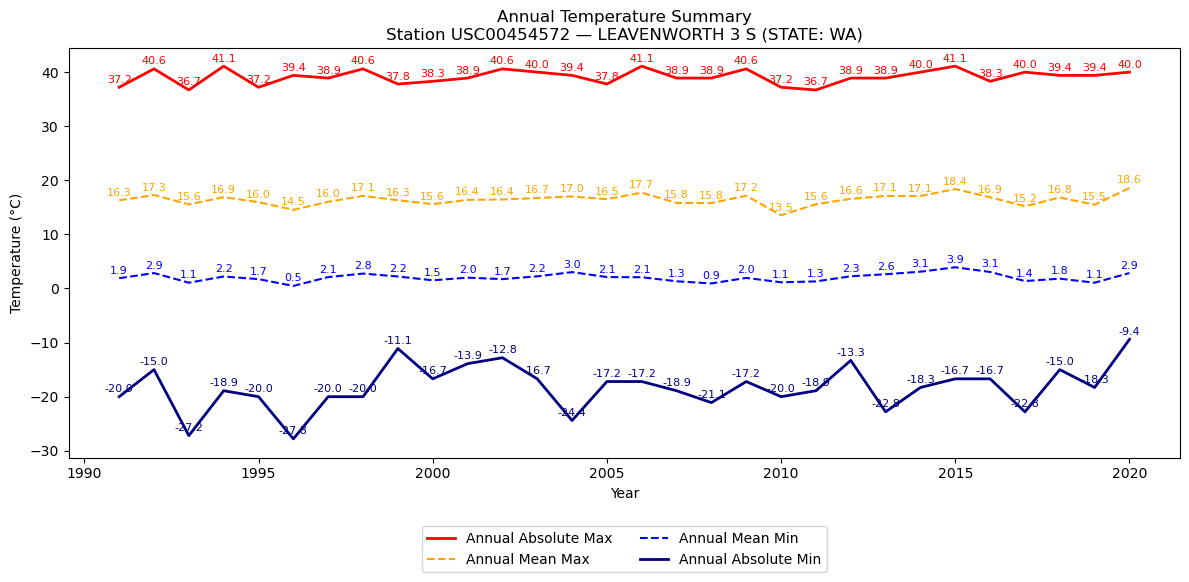

In [ ]:
import matplotlib.pyplot as plt

# Filter for one station
station_df = final_df_annual[final_df_annual['ID']
                             == selected_station_id].sort_values('YEAR')

# Prepare title elements (name and state)
station_meta = final_df_annual[final_df_annual['ID'] ==
                               selected_station_id][['UKN', 'NAME']].dropna().iloc[0]
station_name = station_meta['NAME']
station_ukn = station_meta['UKN']

# Plot setup
plt.figure(figsize=(12, 6))

# Plot and annotate each series
for col, color, label in [
    ('record_max_temp_yearly', 'red', 'Annual Absolute Max'),
    ('mean_max_temp_yearly', 'orange', 'Annual Mean Max'),
    ('mean_min_temp_yearly', 'blue', 'Annual Mean Min'),
    ('record_min_temp_yearly', 'navy', 'Annual Absolute Min')
]:
    plt.plot(
        station_df['YEAR'],
        station_df[col],
        label=label,
        color=color,
        linewidth=2 if 'record' in col else 1.5,
        linestyle='--' if 'mean' in col else '-')
    # Add value labels
    for x, y in zip(station_df['YEAR'], station_df[col]):
        if pd.notnull(y):
            plt.text(x, y + .5, f"{y:.1f}", color=color,
                     fontsize=8, ha='center', va='bottom')

# Labels and legend
plt.title(
    f"Annual Temperature Summary\nStation {selected_station_id} — {station_name} (STATE: {station_ukn})")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.grid(False)
plt.tight_layout()
plt.show()